 # QR CODE AUTHENTICATOR

<img src="https://thumbs.dreamstime.com/z/qr-code-authentication-website-isometric-concept-login-form-laptop-screen-smartphone-scanning-barcode-online-verification-218946363.jpg" alt="Online Image" width="500" height="300"/>






In [1]:
#importing the libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def load_images_from_folder(folder, label):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [3]:
originals_path = "D:\qr code\Assignment Data\First Print"
counterfeits_path = "D:\qr code\Assignment Data\Second Print"

original_images, original_labels = load_images_from_folder(originals_path, 0)
counterfeit_images, counterfeit_labels = load_images_from_folder(counterfeits_path, 1)

all_images = original_images + counterfeit_images
all_labels = original_labels + counterfeit_labels


In [4]:
# Dataset summary
print(f"Total Original Images: {len(original_images)}")
print(f"Total Counterfeit Images: {len(counterfeit_images)}")

Total Original Images: 100
Total Counterfeit Images: 100


In [5]:
# Display sample images
def plot_sample_images(images, titles, rows=1, cols=5):
    plt.figure(figsize=(12, 6))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


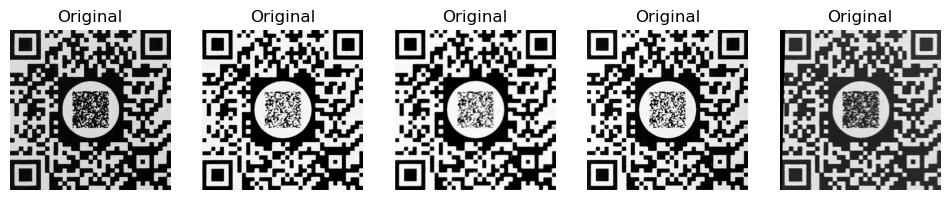

In [6]:
sample_images = original_images[:5] + counterfeit_images[:5]
sample_titles = ['Original'] * 5 + ['Counterfeit'] * 5
plot_sample_images(sample_images, sample_titles)


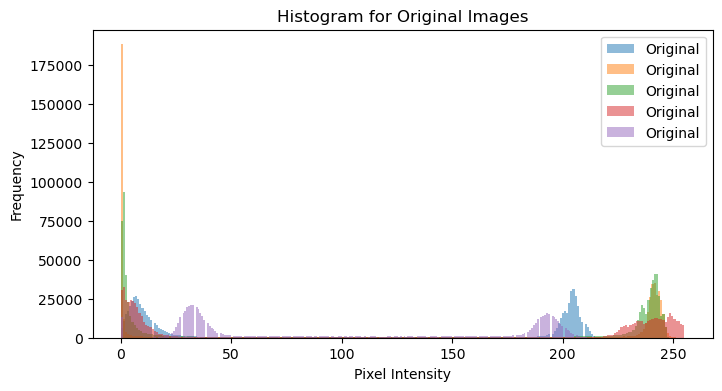

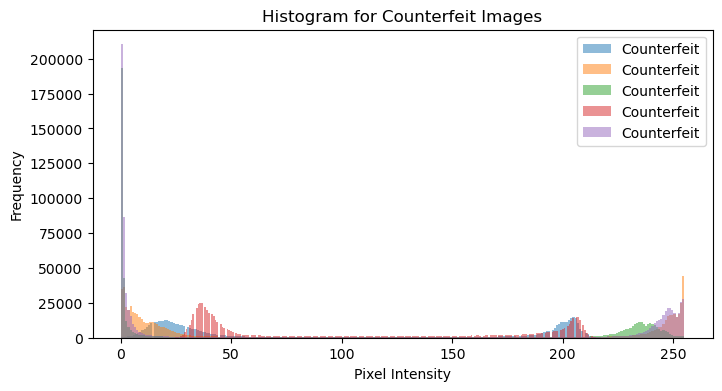

In [7]:
# Computing pixel intensity histograms
def plot_histograms(images, label):
    plt.figure(figsize=(8, 4))
    for img in images[:5]:
        plt.hist(img.ravel(), bins=256, alpha=0.5, label=label)
    plt.title(f"Histogram for {label} Images")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_histograms(original_images, "Original")
plot_histograms(counterfeit_images, "Counterfeit")

In [8]:
# Local Binary Pattern (LBP) Feature Extraction
def extract_lbp_features(image, radius=3, points=24):
    lbp = local_binary_pattern(image, points, radius, method='uniform')
    return lbp

lbp_original = extract_lbp_features(original_images[0])
lbp_counterfeit = extract_lbp_features(counterfeit_images[0])

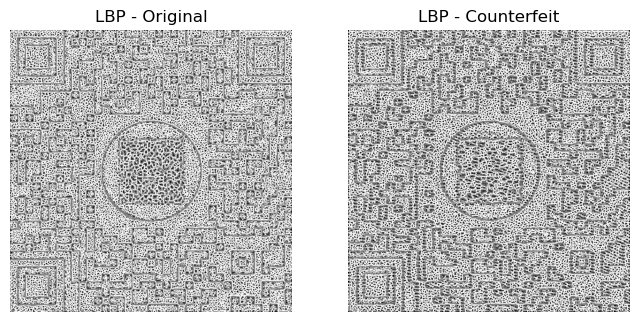

In [9]:
# Plot LBP Features
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(lbp_original, cmap='gray')
plt.title("LBP - Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lbp_counterfeit, cmap='gray')
plt.title("LBP - Counterfeit")
plt.axis("off")

plt.show()

In [38]:
# Feature Extraction Functions

def compute_histogram_features(image):
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    return mean_intensity, std_intensity
    
def compute_edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    return edge_density

def extract_lbp_features(image, radius=3, points=24):
    lbp = local_binary_pattern(image, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), density=True)
    return hist

def compute_blurriness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [11]:
# Computing features for a sample image
sample_original = original_images[0]
sample_counterfeit = counterfeit_images[0]

orig_hist = compute_histogram_features(sample_original)
fake_hist = compute_histogram_features(sample_counterfeit)

orig_edge_density = compute_edge_density(sample_original)
fake_edge_density = compute_edge_density(sample_counterfeit)

orig_lbp = extract_lbp_features(sample_original)
fake_lbp = extract_lbp_features(sample_counterfeit)

orig_blur = compute_blurriness(sample_original)
fake_blur = compute_blurriness(sample_counterfeit)

In [12]:
print("Original Features:")
print(f"Histogram Mean: {orig_hist[0]:.2f}, Std: {orig_hist[1]:.2f}")
print(f"Edge Density: {orig_edge_density:.5f}")
print(f"Blurriness Score: {orig_blur:.2f}")

Original Features:
Histogram Mean: 98.48, Std: 93.39
Edge Density: 12.03315
Blurriness Score: 344.05


In [13]:
print("\nCounterfeit Features:")
print(f"Histogram Mean: {fake_hist[0]:.2f}, Std: {fake_hist[1]:.2f}")
print(f"Edge Density: {fake_edge_density:.5f}")
print(f"Blurriness Score: {fake_blur:.2f}")


Counterfeit Features:
Histogram Mean: 97.37, Std: 82.50
Edge Density: 17.18649
Blurriness Score: 262.12


In [14]:
# Feature Extraction Functions
def compute_histogram_features(image):
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    return [mean_intensity, std_intensity]

def compute_edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    return [edge_density]

def extract_lbp_features(image, radius=3, points=24):
    lbp = local_binary_pattern(image, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), density=True)
    return hist.tolist()

def compute_blurriness(image):
    return [cv2.Laplacian(image, cv2.CV_64F).var()]

In [15]:
# Extracting features for all images
features = []
for img in all_images:
    img_features = (compute_histogram_features(img) +
                    compute_edge_density(img) +
                    extract_lbp_features(img) +
                    compute_blurriness(img))
    features.append(img_features)

In [16]:
# Convert to NumPy array
X = np.array(features)
y = np.array(all_labels)

## Model Creation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [24]:
IMG_SIZE = 128 
BATCH_SIZE = 32
EPOCHS = 50
# Load images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to fixed shape
            images.append(img)
            labels.append(label)
    return images, labels

# Load dataset
originals_path = "D:\qr code\Assignment Data\First Print"
counterfeits_path = "D:\qr code\Assignment Data\Second Print"

original_images, original_labels = load_images_from_folder(originals_path, 0)
counterfeit_images, counterfeit_labels = load_images_from_folder(counterfeits_path, 1)

# Combining data
all_images = np.array(original_images + counterfeit_images)
all_labels = np.array(original_labels + counterfeit_labels)

all_images = all_images / 255.0

# Expanding dimensions 
all_images = np.expand_dims(all_images, axis=-1) 



In [25]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])



D:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Epoch 1/50


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.5082 - loss: 0.8568 - val_accuracy: 0.5250 - val_loss: 0.6967
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.4765 - loss: 0.7079 - val_accuracy: 0.5250 - val_loss: 0.6925
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.4062 - loss: 0.6949 - val_accuracy: 0.5250 - val_loss: 0.6922
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4505 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6921
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.5496 - loss: 0.6928 - val_accuracy: 0.6000 - val_loss: 0.6909
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.6004 - loss: 0.6908 - val_accuracy: 0.4750 - val_loss: 0.6863
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.5577 - loss: 0.6922 - val_accuracy: 0.5250 - val_loss: 0.6777
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.5096 - loss: 0.6875 - val_accuracy: 0.5250 - val_loss: 0.6890
Epo

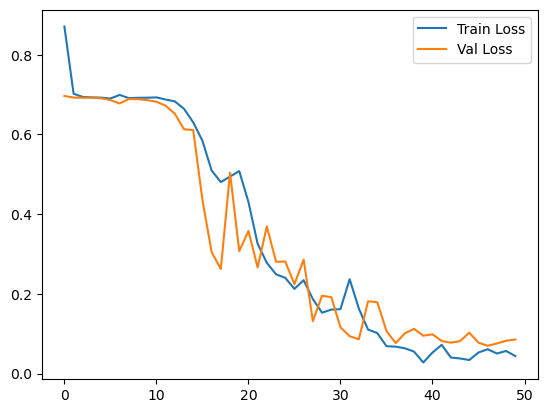

In [27]:
# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


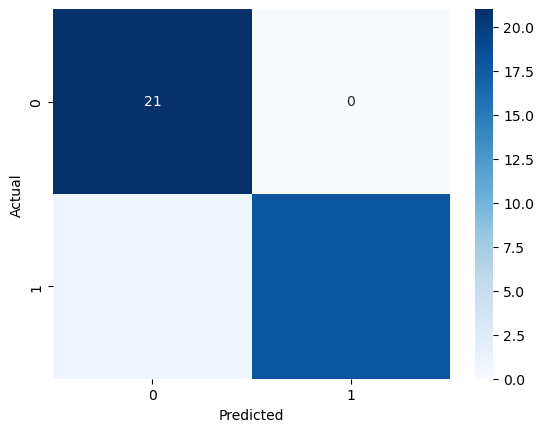

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [41]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.95      1.00      0.97        18

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



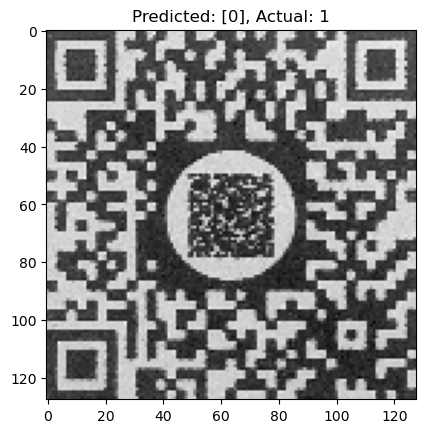

In [29]:
misclassified_idxs = np.where(y_pred.flatten() != y_test)[0]
for idx in misclassified_idxs[:5]:  
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"Predicted: {y_pred[idx]}, Actual: {y_test[idx]}")
    plt.show()


In [30]:
model.save("qr_auth_model.h5")


In [31]:
import tensorflow as tf

model = tf.keras.models.load_model("qr_auth_model.h5")

# Convert model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("qr_auth_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")


INFO:tensorflow:Assets written to: C:\Users\ASHNOO~1\AppData\Local\Temp\tmp6b8qzgva\assets


INFO:tensorflow:Assets written to: C:\Users\ASHNOO~1\AppData\Local\Temp\tmp6b8qzgva\assets


Saved artifact at 'C:\Users\ASHNOO~1\AppData\Local\Temp\tmp6b8qzgva'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2091220706960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220704464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220704848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220706768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220706576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220708688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220706192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220710800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220707536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2091220711952: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLit